In [1]:
!ls ../experiments/logs

arch_easy   difficulty	   lr_sweep_llama     new_lr_sweep_llama
arch_evals  hyena_start    misc		      new_lr_sweep_nodrop
arch_sweep  lr_sweep	   new_lr_sweep       pcfg_easy
attn_test3  lr_sweep_gpt2  new_lr_sweep_gpt2  pcfg_medium


In [2]:
import glob
import os
import pandas as pd
import plotnine as p9
from tqdm import tqdm

In [3]:
p9.theme_set(
    p9.theme_bw() +
    p9.theme(
        axis_text_x=p9.element_text(rotation=90),
        text=p9.element_text(family="P052"),
        # strip_text=p9.element_text(size=8)
    )
)

In [4]:
arch_names = {
    "attention": "Attention",
    "based": "Based",
    "base_conv": "BaseConv",
    "h3": "H3",
    "hyena": "Hyena",
    "mamba": "Mamba",
}

In [5]:
dirs = [
    "../experiments/logs/pcfg_easy/**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium/**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy/**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium/**/test/SummaryEvaluator.csv",
]

In [6]:
all_files = []
for d in dirs:
    all_files.extend(list(glob.glob(d)))
dfs = []
for file in tqdm(all_files):
    evaluator = file.split("/")[-1].split(".")[0]
    arch, dim, lr = os.path.dirname(file).split("/")[-2].split(".")[0].split("___")
    log = pd.read_csv(file)
    log = log[(log["step"] % 5000) == 0]
    log["identifier"] = file
    log["arch"] = arch
    log["dim"] = int(dim)
    log["lr"] = float(lr)
    log["evaluator"] = evaluator
    log["step_rel"] = log["step"] / log["step"].max()
    log["layers"] = 2
    log["dataset"] = os.path.dirname(file).split("/")[-3]
    log = log.groupby(["variable", "step", "evaluator", "step_rel", "identifier", "arch", "dim", "lr", "layers", "dataset"]).mean().reset_index()
    dfs.append(log)
print(len(dfs))
df = pd.concat(dfs)
df = df.groupby(["variable", "step", "evaluator", "step_rel", "identifier", "arch", "dim", "lr", "layers", "dataset"]).mean().reset_index()
df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 544/544 [04:36<00:00,  1.97it/s]


544


,variable,step,evaluator,step_rel,identifier,arch,dim,lr,layers,dataset,value
0,PARENT.query_item.argmax,0,SummaryEvaluator,0.0,../experiments/logs/pcfg_easy/attention___128_...,attention,128,0.00100,2,pcfg_easy,0.000000
1,PARENT.query_item.argmax,0,SummaryEvaluator,0.0,../experiments/logs/pcfg_easy/attention___128_...,attention,128,0.00010,2,pcfg_easy,0.000000
2,PARENT.query_item.argmax,0,SummaryEvaluator,0.0,../experiments/logs/pcfg_easy/attention___128_...,attention,128,0.00300,2,pcfg_easy,0.000000
3,PARENT.query_item.argmax,0,SummaryEvaluator,0.0,../experiments/logs/pcfg_easy/attention___128_...,attention,128,0.00030,2,pcfg_easy,0.000000
4,PARENT.query_item.argmax,0,SummaryEvaluator,0.0,../experiments/logs/pcfg_easy/attention___128_...,attention,128,0.00003,2,pcfg_easy,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
39979,query_item.pred_prob,100000,SummaryEvaluator,1.0,../experiments/logs/pcfg_medium/mamba___64___1...,mamba,64,0.00100,2,pcfg_medium,0.798719
39980,query_item.pred_prob,100000,SummaryEvaluator,1.0,../experiments/logs/pcfg_medium/mamba___64___1...,mamba,64,0.00010,2,pcfg_medium,0.625678
39981,query_item.pred_prob,100000,SummaryEvaluator,1.0,../experiments/logs/pcfg_medium/mamba___64___3...,mamba,64,0.00300,2,pcfg_medium,0.824590
39982,query_item.pred_prob,100000,SummaryEvaluator,1.0,../experiments/logs/pcfg_medium/mamba___64___3...,mamba,64,0.00030,2,pcfg_medium,0.733305


In [7]:
df["arch"] = df["arch"].map(arch_names)

In [8]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()
subset_df["dataset"] = subset_df["dataset"].map({
    "pcfg_easy": "$L = 5$",
    "pcfg_medium": "$L = 10$",
})
subset_df["dataset"] = pd.Categorical(subset_df["dataset"], categories=["$L = 5$", "$L = 10$"], ordered=True)
# subset_df = subset_df[["dim", "arch", "value"]].groupby(["dim", "arch"]).max().reset_index()
# subset_df

pivoted = subset_df.copy()
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{lllllllllll}
\toprule
 & \multicolumn{10}{r}{value} \\
dataset & \multicolumn{5}{r}{$L = 5$} & \multicolumn{5}{r}{$L = 10$} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 68.44 & 90.31 & 93.75 & 95.31 & 96.25 & 50.94 & 56.88 & 75.62 & 80.62 & 80.94 \\
BaseConv & 66.56 & 75.31 & 80.00 & 85.62 & 88.12 & 51.88 & 57.81 & 59.69 & 60.00 & 64.06 \\
Based & 84.38 & 88.44 & 92.50 & 93.44 & 93.75 & 58.44 & 77.19 & 73.44 & 71.25 & 74.69 \\
H3 & 82.50 & 87.19 & 90.62 & 93.75 & 94.06 & NaN & NaN & NaN & NaN & NaN \\
Hyena & 73.44 & 79.06 & 86.25 & 92.81 & 93.75 & 50.31 & 58.13 & 60.94 & 71.25 & 63.44 \\
Mamba & 88.44 & 93.12 & 95.94 & 95.94 & 96.88 & 76.56 & 83.12 & 82.19 & 88.75 & 90.00 \\
\bottomrule
\end{tabular}



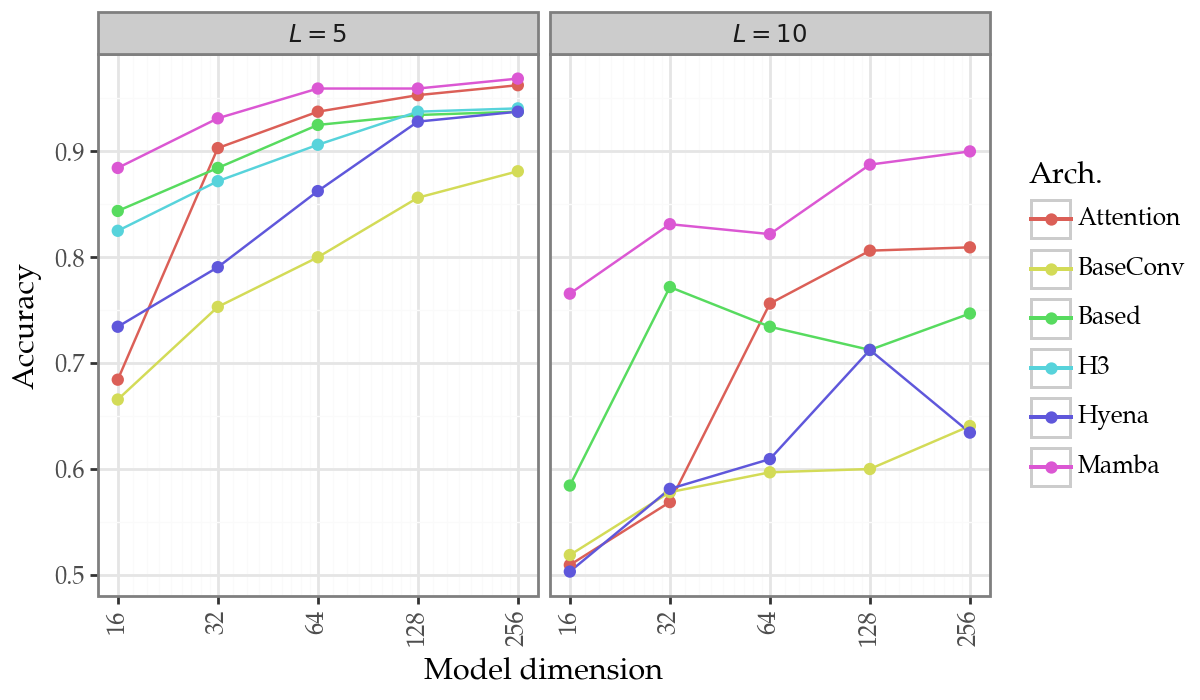

In [9]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()
subset_df["dataset"] = subset_df["dataset"].map({
    "pcfg_easy": "$L = 5$",
    "pcfg_medium": "$L = 10$",
})
subset_df["dataset"] = pd.Categorical(subset_df["dataset"], categories=["$L = 5$", "$L = 10$"], ordered=True)
# subset_df = subset_df[["dim", "arch", "value"]].groupby(["dim", "arch"]).max().reset_index()
# subset_df

plot = (
    p9.ggplot(subset_df, p9.aes(x="dim", y="value", group="arch", color="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_wrap("~dataset") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.") +
    p9.theme(figure_size=(6, 3.5))
)
plot.show()

In [10]:
dirs = [
    "../experiments/logs/pcfg_easy/**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium/**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy/**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium/**/test/InterchangeEvaluator.csv",
]

In [11]:
all_files = []
for d in dirs:
    all_files.extend(list(glob.glob(d)))
dfs = []
for file in tqdm(all_files):
    evaluator = file.split("/")[-1].split(".")[0]
    arch, dim, lr = os.path.dirname(file).split("/")[-2].split(".")[0].split("___")
    log = pd.read_csv(file)
    log = log[(log["step"] % 5000) == 0]
    log["identifier"] = file
    log["arch"] = arch
    log["dim"] = int(dim)
    log["lr"] = float(lr)
    log["evaluator"] = evaluator
    log["step_rel"] = log["step"] / log["step"].max()
    log["layers"] = 2
    log["dataset"] = os.path.dirname(file).split("/")[-3]
    log = log.groupby(["variable", "step", "evaluator", "step_rel", "identifier", "arch", "dim", "lr", "layers", "dataset"]).mean().reset_index()
    dfs.append(log)
print(len(dfs))
df_int = pd.concat(dfs)
df_int = df_int.groupby(["variable", "step", "evaluator", "step_rel", "identifier", "arch", "dim", "lr", "layers", "dataset"]).mean().reset_index()
df_int["arch"] = df_int["arch"].map(arch_names)
df_int.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 544/544 [02:50<00:00,  3.18it/s]


544


,variable,step,evaluator,step_rel,identifier,arch,dim,lr,layers,dataset,value
0,0.PARENT.query_item_orig.divider.attention_inp...,0,InterchangeEvaluator,0.0,../experiments/logs/pcfg_easy/attention___128_...,Attention,128,0.00100,2,pcfg_easy,0.0
1,0.PARENT.query_item_orig.divider.attention_inp...,0,InterchangeEvaluator,0.0,../experiments/logs/pcfg_easy/attention___128_...,Attention,128,0.00010,2,pcfg_easy,0.0
2,0.PARENT.query_item_orig.divider.attention_inp...,0,InterchangeEvaluator,0.0,../experiments/logs/pcfg_easy/attention___128_...,Attention,128,0.00300,2,pcfg_easy,0.0
3,0.PARENT.query_item_orig.divider.attention_inp...,0,InterchangeEvaluator,0.0,../experiments/logs/pcfg_easy/attention___128_...,Attention,128,0.00030,2,pcfg_easy,0.0
4,0.PARENT.query_item_orig.divider.attention_inp...,0,InterchangeEvaluator,0.0,../experiments/logs/pcfg_easy/attention___128_...,Attention,128,0.00003,2,pcfg_easy,0.0


In [12]:
position = "target_item_orig"
metric = f"1.PARENT.query_item_orig.{position}.block_input.restored_prob"
corrupted = f"corrupted.PARENT.query_item_orig.{position}.block_input.restored_prob"
diff = f"1.PARENT.query_item_orig.{position}.block_input.prob_diff"
original = f"original.PARENT.query_item_orig.{position}.block_input.restored_prob"

subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df_int = df_int[(df_int["variable"].isin([metric, corrupted, diff, original])) & (df_int["step_rel"] == 1.0)]
subset_df_int = pd.concat([subset_df_int, subset_df])
subset_df_int = subset_df_int[["dim", "arch", "lr", "variable", "value", "dataset"]].pivot(index=["dim", "arch", "lr", "dataset"], columns="variable").reset_index()
subset_df_int.columns = [col[1] if col[1] != '' else col[0] for col in subset_df_int.columns]
# subset_df_int[metric] = (subset_df_int[metric] - subset_df_int[corrupted]) / (subset_df_int[original] - subset_df_int[corrupted])
subset_df_int[metric] = (subset_df_int[diff]) / (subset_df_int[original] - (subset_df_int[metric] - subset_df_int[diff]))
subset_df_int = subset_df_int.rename(columns={
    "query_item.argmax": "Accuracy",
    metric: "Association",
    corrupted: "Corrupted",
    diff: "Diff",
    original: "Original",
})
subset_df_int = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax()] # get most accurate ones
subset_df_int["dataset"] = subset_df_int["dataset"].map({
    "pcfg_easy": "$L = 5$",
    "pcfg_medium": "$L = 10$",
})
subset_df_int["dataset"] = pd.Categorical(subset_df_int["dataset"], categories=["$L = 5$", "$L = 10$"], ordered=True)
# subset_df_int

pivoted = subset_df_int.copy()[["dim", "arch", "dataset", "Association"]]
pivoted["Association"] = pivoted["Association"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{lllllllllll}
\toprule
 & \multicolumn{10}{r}{Association} \\
dataset & \multicolumn{5}{r}{$L = 5$} & \multicolumn{5}{r}{$L = 10$} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 23.09 & 109.29 & 102.24 & 107.19 & 102.69 & 11.55 & -23.18 & 112.20 & 117.13 & 109.59 \\
BaseConv & 39.85 & 35.55 & 51.43 & 51.07 & 67.14 & 24.27 & 44.54 & 63.10 & 56.31 & 62.07 \\
Based & 12.58 & 16.75 & 96.72 & 92.57 & 95.18 & 17.93 & 97.97 & 93.01 & 93.65 & 94.01 \\
H3 & 6.50 & 10.06 & 2.64 & 7.33 & 3.02 & NaN & NaN & NaN & NaN & NaN \\
Hyena & 19.92 & 14.58 & 4.36 & 1.14 & 9.36 & 22.37 & -1.81 & 17.26 & 5.17 & 3.98 \\
Mamba & 2.33 & 0.21 & -0.52 & 3.01 & -0.33 & 1.33 & 1.21 & 0.57 & 1.42 & 1.39 \\
\bottomrule
\end{tabular}



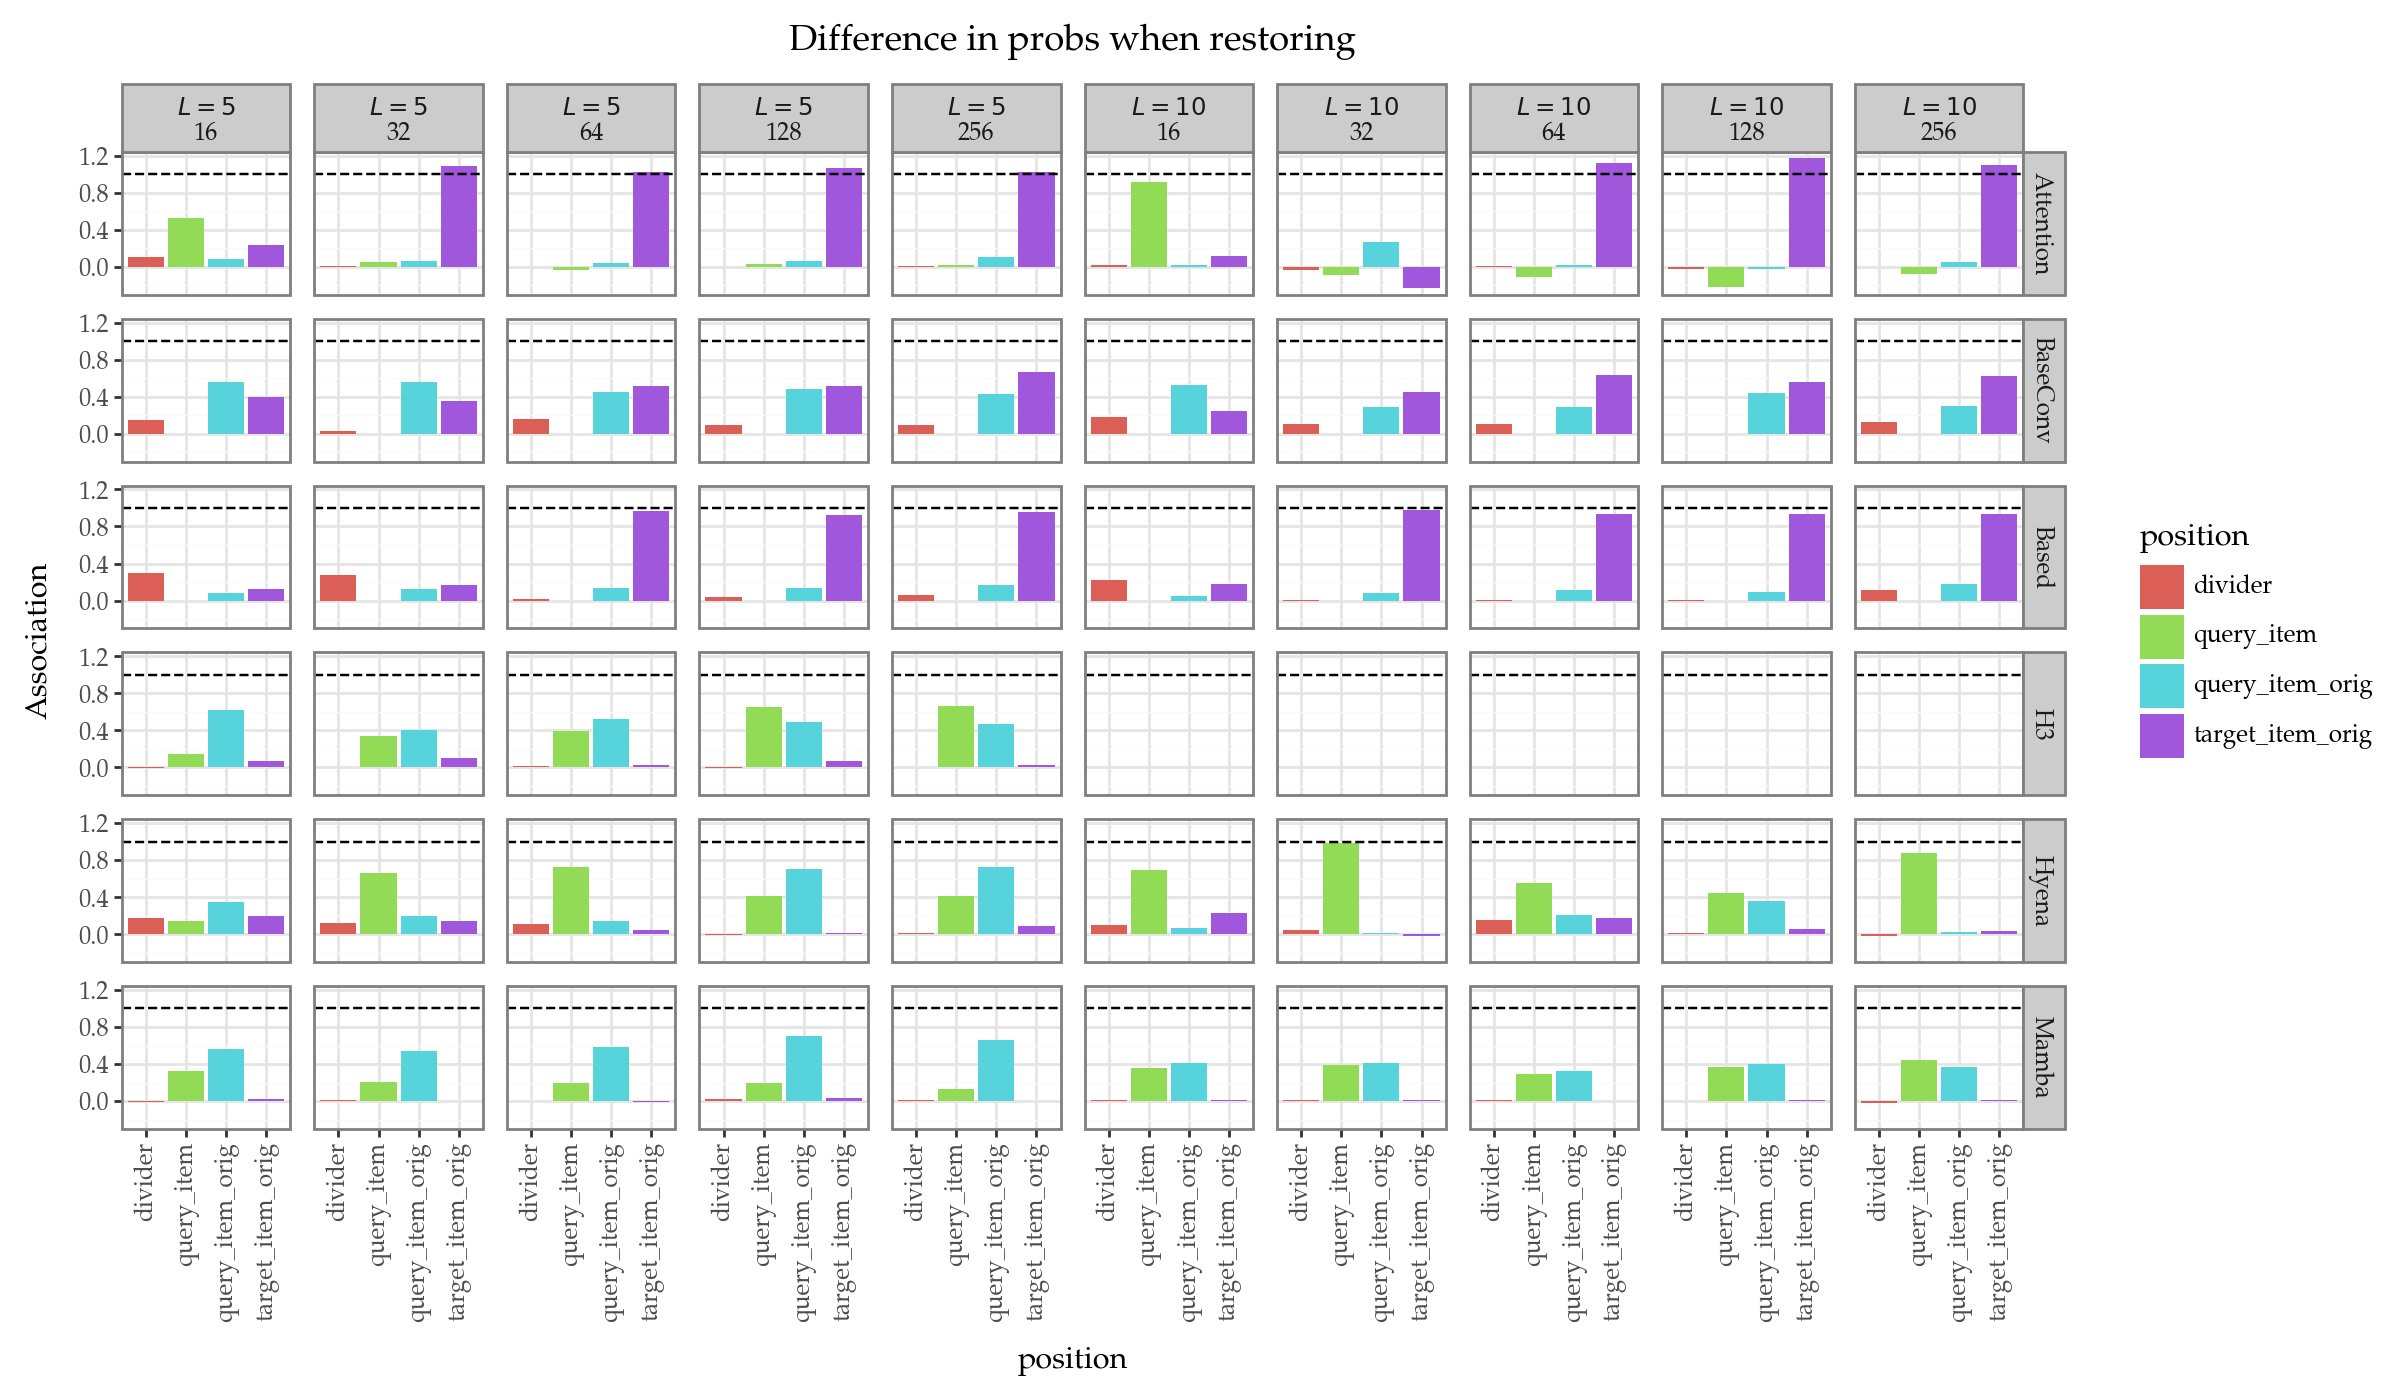

In [14]:
pos_dfs = []
measure = "prob"
corrupt = "query_item_orig"
for position in ["target_item_orig", "query_item_orig", "query_item", "divider"]:
    metric = f"1.PARENT.{corrupt}.{position}.block_input.restored_{measure}"
    corrupted = f"corrupted.PARENT.{corrupt}.{position}.block_input.restored_{measure}"
    diff = f"1.PARENT.{corrupt}.{position}.block_input.{measure}_diff"
    original = f"original.PARENT.{corrupt}.{position}.block_input.restored_{measure}"
    
    subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
    subset_df_int = df_int[(df_int["variable"].isin([metric, corrupted, diff, original])) & (df_int["step_rel"] == 1.0)]
    subset_df_int = pd.concat([subset_df_int, subset_df])
    subset_df_int = subset_df_int[["dim", "arch", "lr", "variable", "value", "dataset"]].pivot(index=["dim", "arch", "lr", "dataset"], columns="variable").reset_index()
    subset_df_int.columns = [col[1] if col[1] != '' else col[0] for col in subset_df_int.columns]
    # subset_df_int[metric] = (subset_df_int[metric] - subset_df_int[corrupted]) / (subset_df_int[original] - subset_df_int[corrupted])
    subset_df_int[metric] = (subset_df_int[diff]) / (subset_df_int[original] - (subset_df_int[metric] - subset_df_int[diff]))
    subset_df_int = subset_df_int.rename(columns={
        "query_item.argmax": "Accuracy",
        metric: "Association",
        corrupted: "Corrupted",
        diff: "Diff",
        original: "Original",
    })
    subset_df_int = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax()] # get most accurate ones
    subset_df_int["dataset"] = subset_df_int["dataset"].map({
        "pcfg_easy": "$L = 5$",
        "pcfg_medium": "$L = 10$",
    })
    subset_df_int["dataset"] = pd.Categorical(subset_df_int["dataset"], categories=["$L = 5$", "$L = 10$"], ordered=True)
    subset_df_int["position"] = position
    pos_dfs.append(subset_df_int[["dim", "arch", "dataset", "position", "Association"]])

pos_df = pd.concat(pos_dfs)

plot = (
    p9.ggplot(pos_df, p9.aes(x="position", y="Association", fill="position")) +
    p9.facet_grid("arch ~ dataset + dim") +
    p9.geom_bar(stat="identity") +
    p9.theme(figure_size=(12, 7)) +
    p9.geom_hline(yintercept=1, linetype="dashed") +
    p9.labs(title=f"Difference in {measure}s when restoring")
)
plot.show()
# pos_df.pivot(index=["dim", "arch", "lr", "dataset"], columns=["position"])


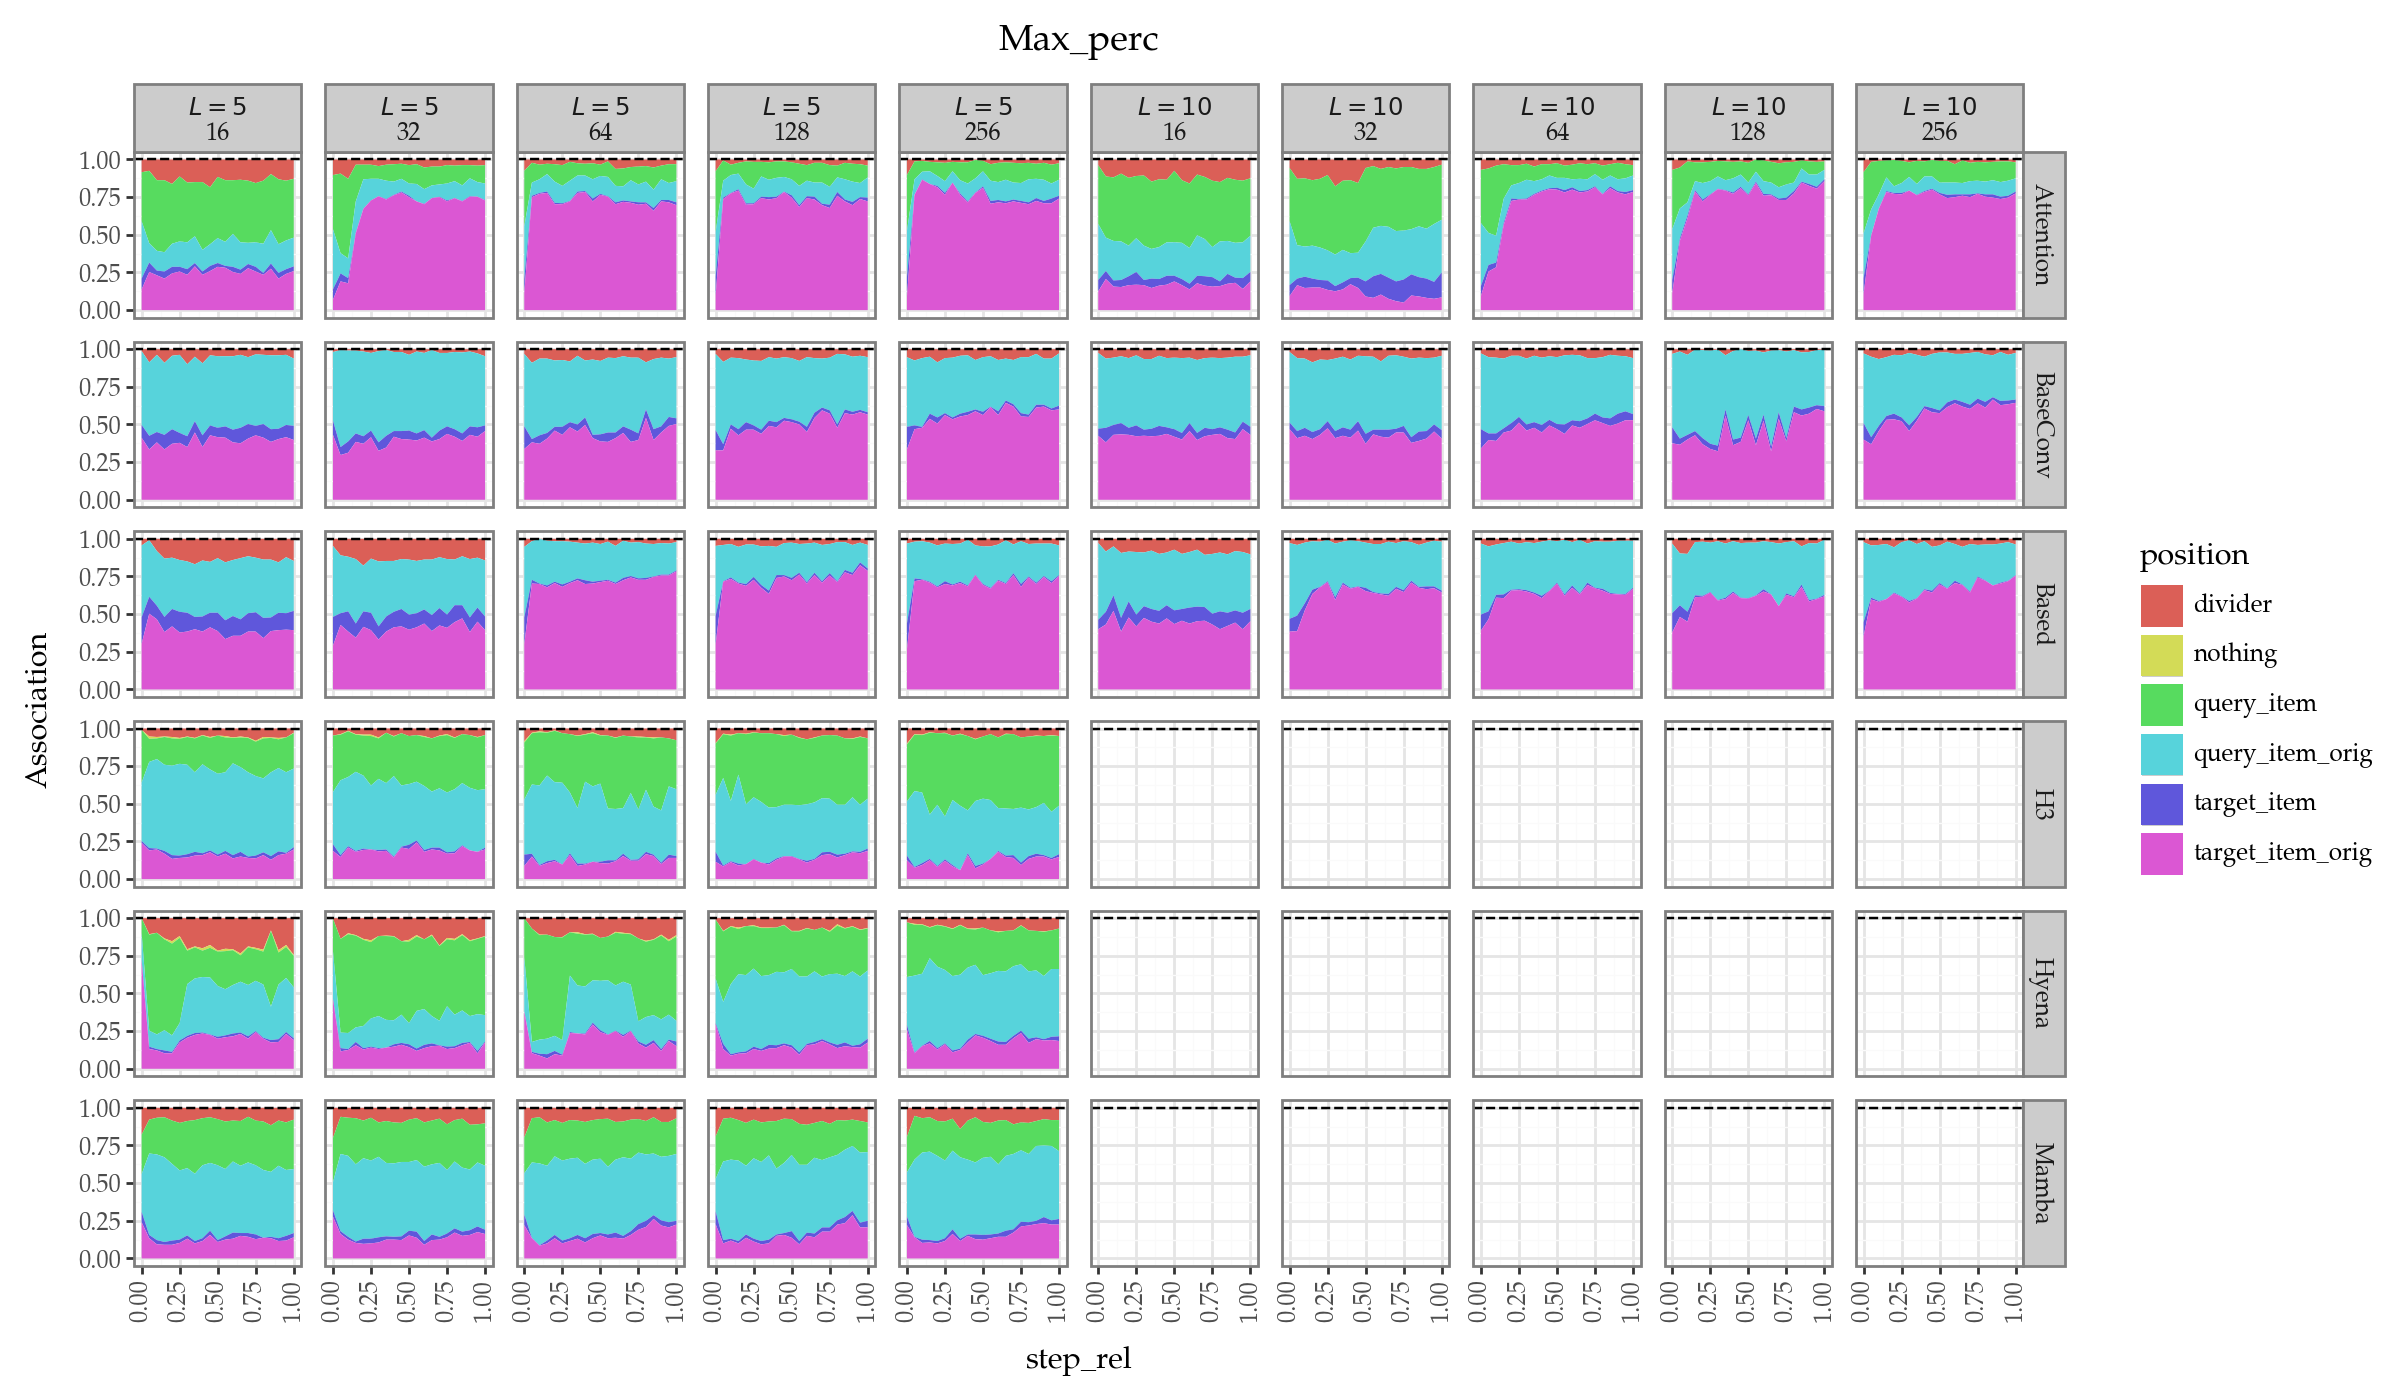

In [200]:
pos_dfs = []
measure = "prob"
corrupt = "query_item_orig"
for position in ["target_item_orig", "query_item_orig", "query_item", "divider", "nothing", "target_item"]:
    metric = f"1.PARENT.{corrupt}.{position}.block_input.max_perc"

    subset_df = df[(df["variable"] == "query_item.argmax")]# & (df["step_rel"] == 1.0)]
    subset_df_int = df_int[(df_int["variable"].isin([metric]))]# & (df_int["step_rel"] == 1.0)]
    subset_df_int = pd.concat([subset_df_int, subset_df])
    subset_df_int = subset_df_int[["dim", "arch", "lr", "variable", "value", "dataset", "step_rel"]].pivot(index=["dim", "arch", "lr", "dataset", "step_rel"], columns="variable").reset_index()
    subset_df_int.columns = [col[1] if col[1] != '' else col[0] for col in subset_df_int.columns]
    subset_df_int = subset_df_int.rename(columns={
        "query_item.argmax": "Accuracy",
        metric: "Association",
    })
    subset_df_int = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset", "step_rel"])["Accuracy"].idxmax()] # get most accurate ones
    subset_df_int["dataset"] = subset_df_int["dataset"].map({
        "pcfg_easy": "$L = 5$",
        "pcfg_medium": "$L = 10$",
    })
    subset_df_int["dataset"] = pd.Categorical(subset_df_int["dataset"], categories=["$L = 5$", "$L = 10$"], ordered=True)
    subset_df_int["position"] = position
    pos_dfs.append(subset_df_int[["dim", "arch", "dataset", "position", "Association", "step_rel"]])

pos_df = pd.concat(pos_dfs)

plot = (
    p9.ggplot(pos_df, p9.aes(x="step_rel", y="Association", fill="position")) +
    p9.facet_grid("arch ~ dataset + dim") +
    p9.geom_area(stat="identity") +
    p9.theme(figure_size=(12, 7)) +
    p9.geom_hline(yintercept=1, linetype="dashed") +
    p9.labs(title=f"Max_perc")
)
plot.show()
# pos_df.pivot(index=["dim", "arch", "lr", "dataset"], columns=["position"])


In [149]:
df["variable"].unique()

array(['PARENT.query_item.argmax', 'PARENT.query_item.kl_div',
       'PARENT.query_item.pred_prob', 'loss', 'query_item.argmax',
       'query_item.kl_div', 'query_item.pred_prob'], dtype=object)

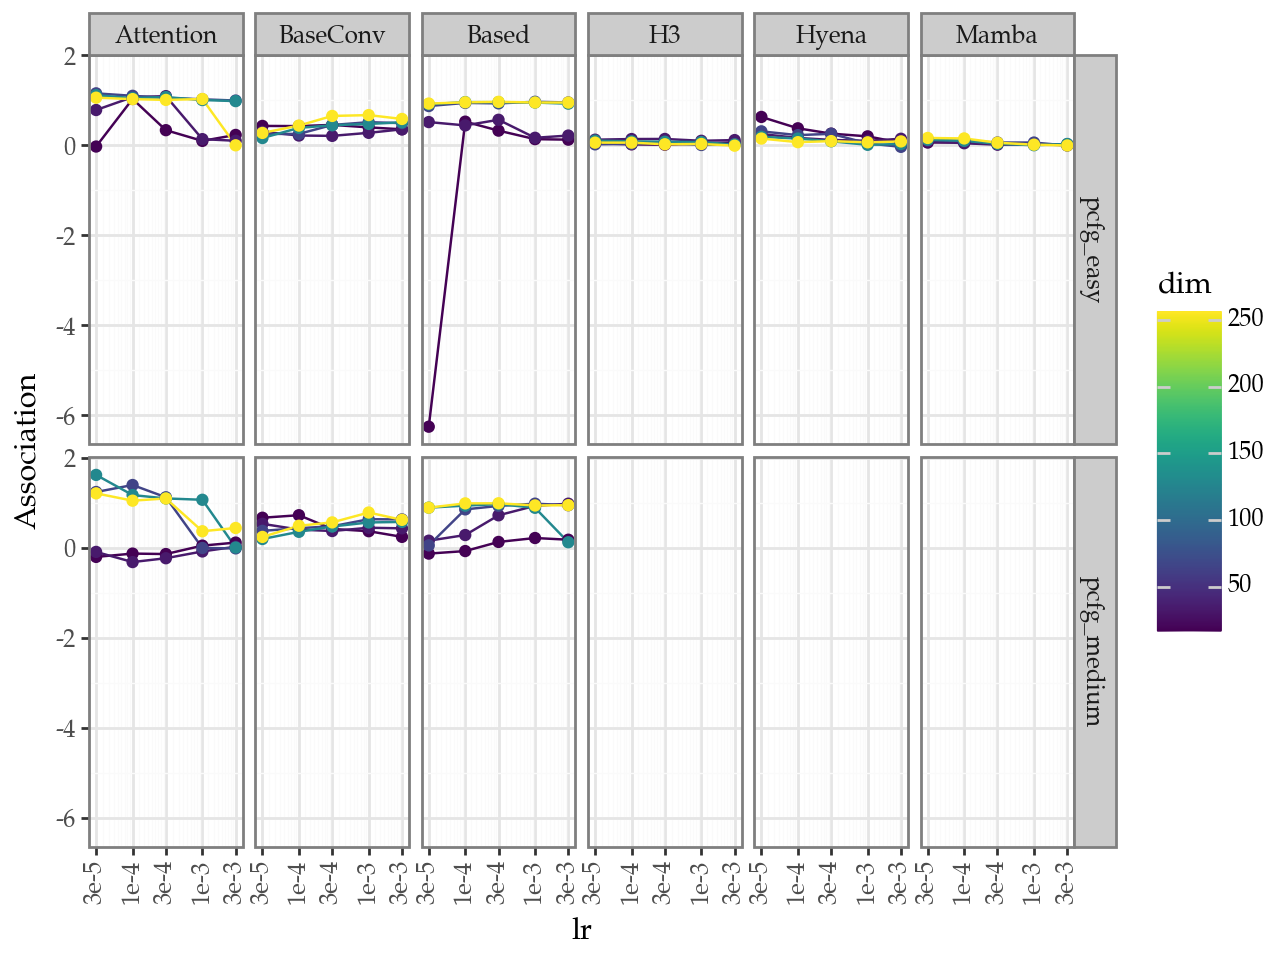

In [189]:
position = "target_item_orig"
metric = f"1.PARENT.query_item_orig.{position}.block_input.restored_prob"
corrupted = f"corrupted.PARENT.query_item_orig.{position}.block_input.restored_prob"
diff = f"1.PARENT.query_item_orig.{position}.block_input.prob_diff"
original = f"original.PARENT.query_item_orig.{position}.block_input.restored_prob"
acc = "query_item.argmax"

subset_df = df[(df["variable"] == acc) & (df["step_rel"] == 1.0)]
subset_df_int = df_int[(df_int["variable"].isin([metric, corrupted, diff, original])) & (df_int["step_rel"] == 1.0)]
subset_df_int = pd.concat([subset_df_int, subset_df])
subset_df_int = subset_df_int[["dim", "arch", "lr", "variable", "value", "dataset"]].pivot(index=["dim", "arch", "lr", "dataset"], columns="variable").reset_index()
subset_df_int.columns = [col[1] if col[1] != '' else col[0] for col in subset_df_int.columns]
# subset_df_int[metric] = (subset_df_int[metric] - subset_df_int[corrupted]) / (subset_df_int[original] - subset_df_int[corrupted])
subset_df_int[metric] = (subset_df_int[diff]) / (subset_df_int[original] - (subset_df_int[metric] - subset_df_int[diff]))
subset_df_int = subset_df_int.rename(columns={
    acc: "Accuracy",
    metric: "Association",
    corrupted: "Corrupted",
    diff: "Diff",
    original: "Original",
})
# print(subset_df_int.sort_values(by=["Association"], ascending=False))

plot = (
    p9.ggplot(subset_df_int, p9.aes(x="lr", y="Association", group="dim", color="dim")) +
    p9.facet_grid("dataset ~ arch") +
    p9.geom_line() +
    p9.geom_point() +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3])
)
plot.show()

/tmp/aryaman/ipykernel_506425/648833079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/aryaman/ipykernel_506425/648833079.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


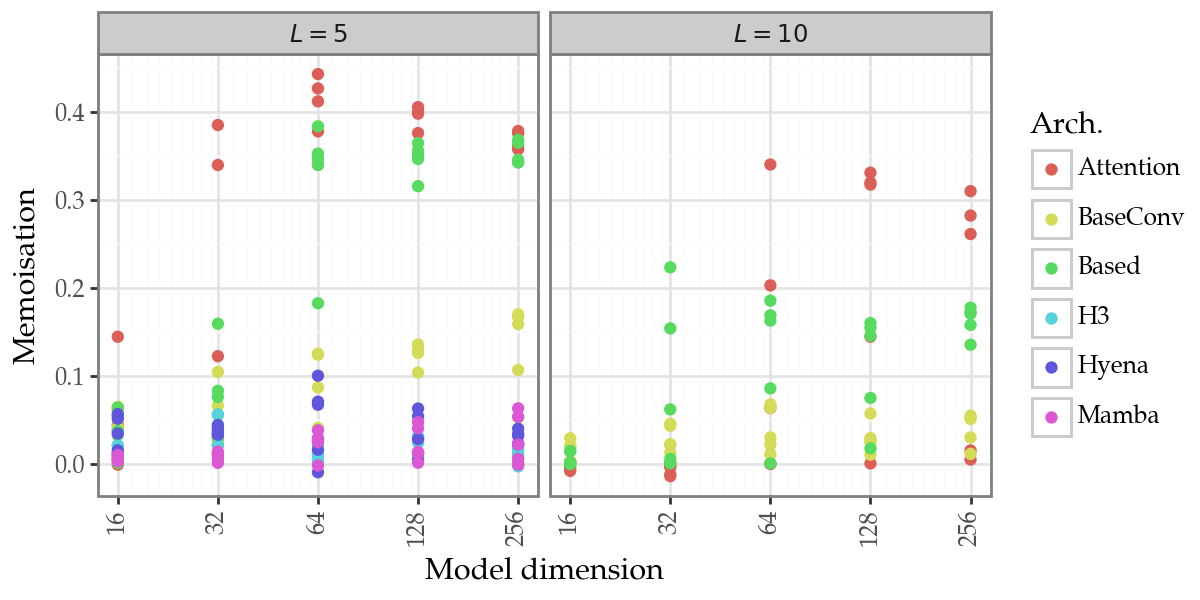

In [17]:
subset_df = df_int[(df_int["variable"] == "1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff") & (df_int["step_rel"] == 1.0)]
# subset_df = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()
subset_df["dataset"] = subset_df["dataset"].map({
    "pcfg_easy": "$L = 5$",
    "pcfg_medium": "$L = 10$",
})
subset_df["dataset"] = pd.Categorical(subset_df["dataset"], categories=["$L = 5$", "$L = 10$"], ordered=True)

plot = (
    p9.ggplot(subset_df, p9.aes(x="dim", y="value", group="arch", color="arch")) +
    # p9.stat_summary() +
    # p9.geom_line() +
    p9.geom_point() +
    p9.facet_wrap("~dataset") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(y="Memoisation", x="Model dimension", color="Arch.") +
    p9.theme(figure_size=(6, 3))
)
plot.show()

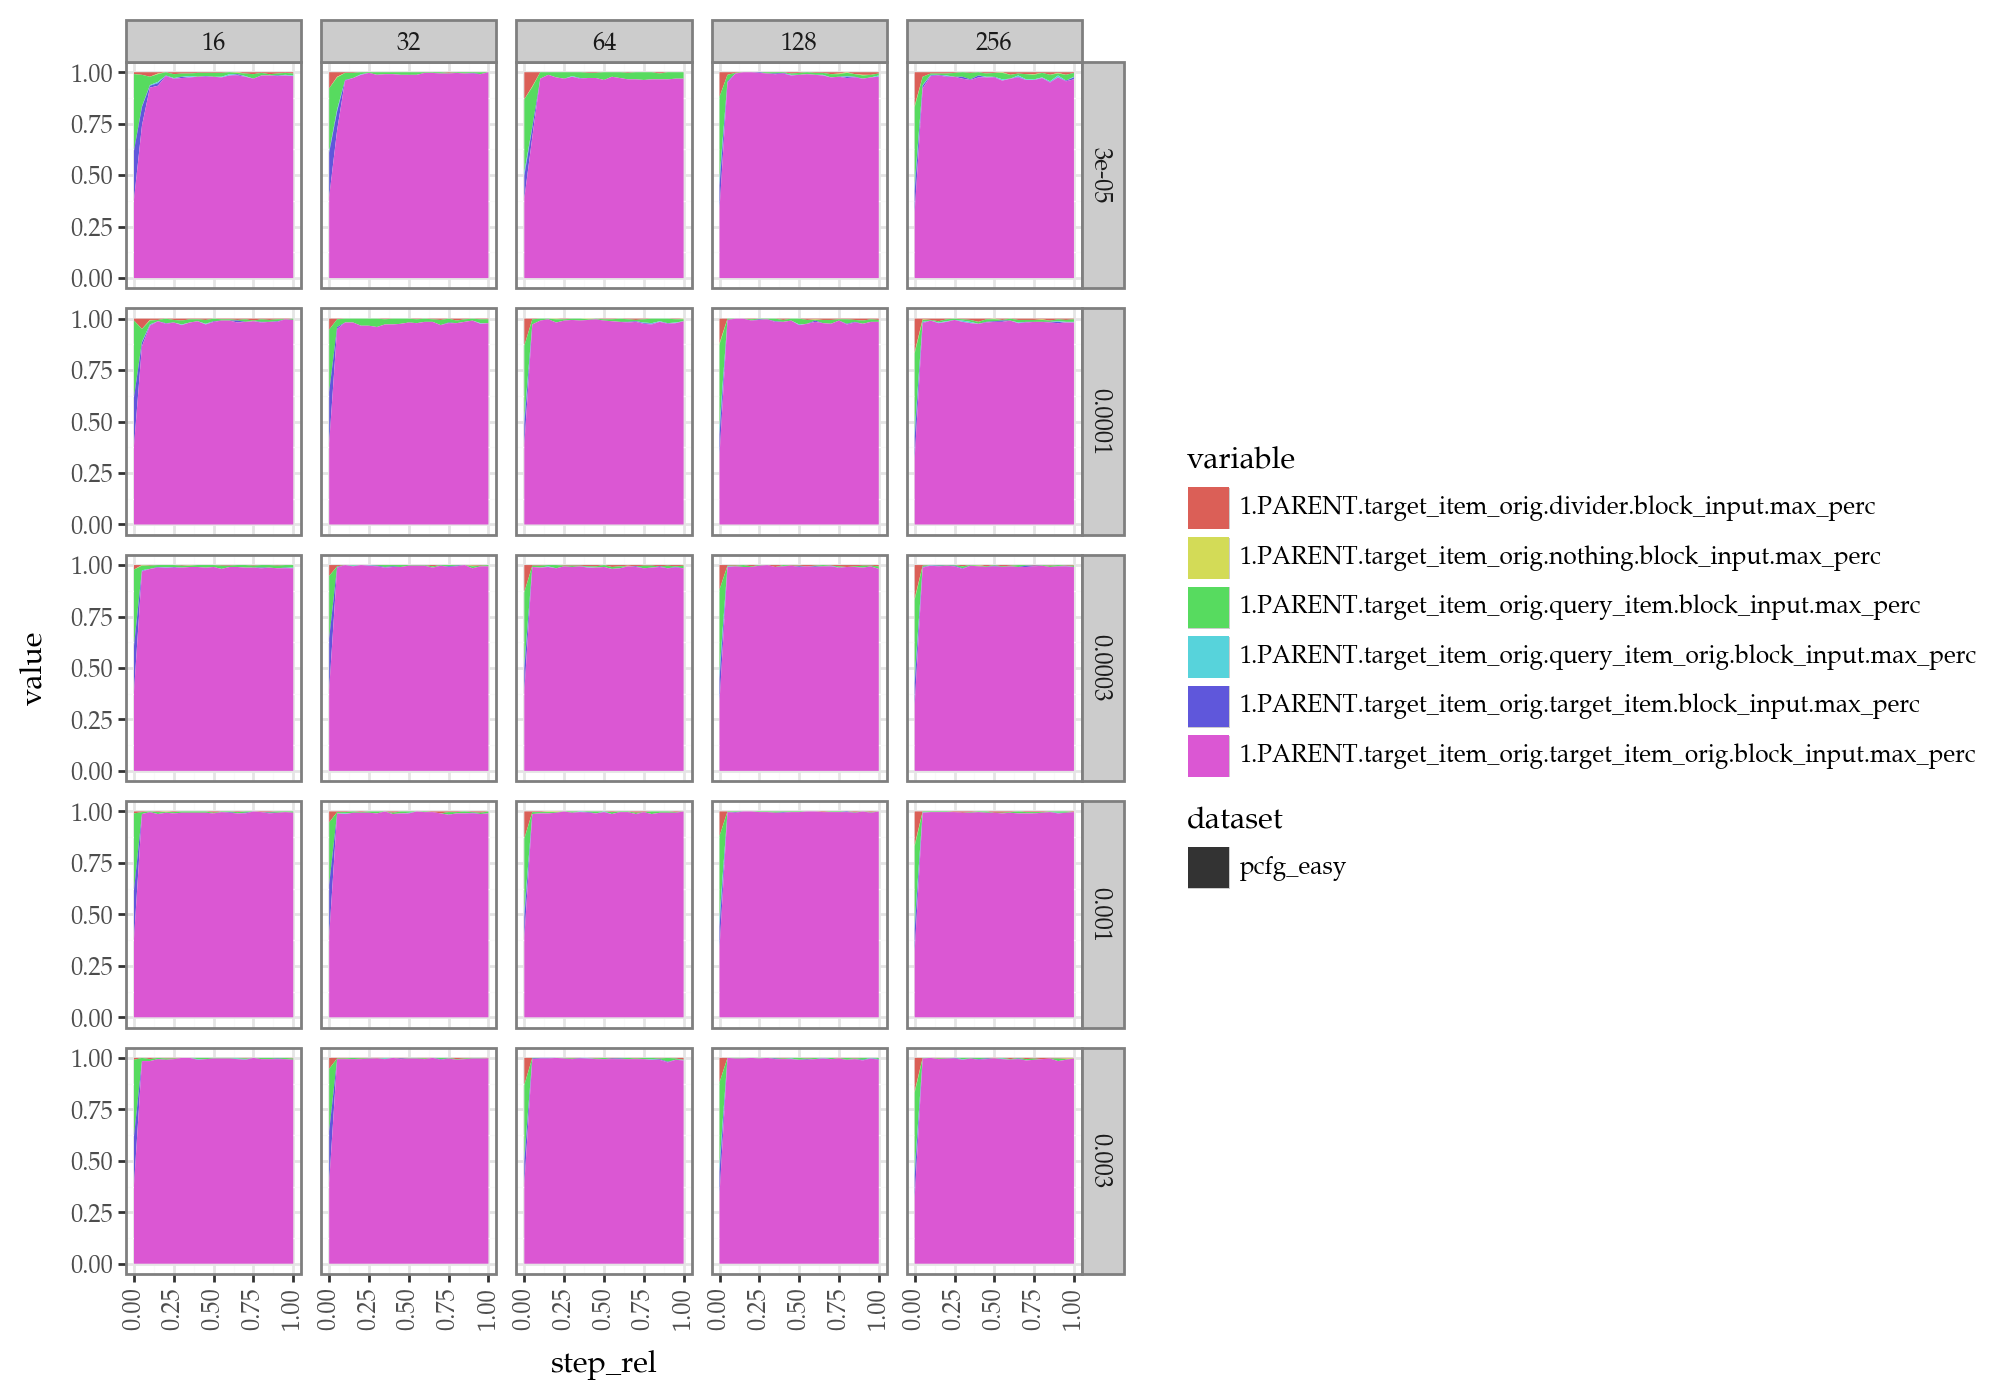

In [48]:
subset_df = df_int[
    (df_int["variable"].str.contains(r"1\.PARENT\.target_item_orig\..*?\.block_input\.max_perc$", regex=True)) &
    (df_int["arch"] == "H3") & 
    (df_int["dataset"] == "pcfg_easy")
]
plot = (
    p9.ggplot(subset_df, p9.aes(x="step_rel", y="value", fill="variable", linetype="dataset", group="variable")) +
    p9.geom_area(position="stack") +
    # p9.geom_point() +
    # p9.geom_point() +
    p9.facet_grid("lr~dim") +
    # p9.scale_x_log10() +
    p9.theme(figure_size=(10, 7))
)
plot.show()

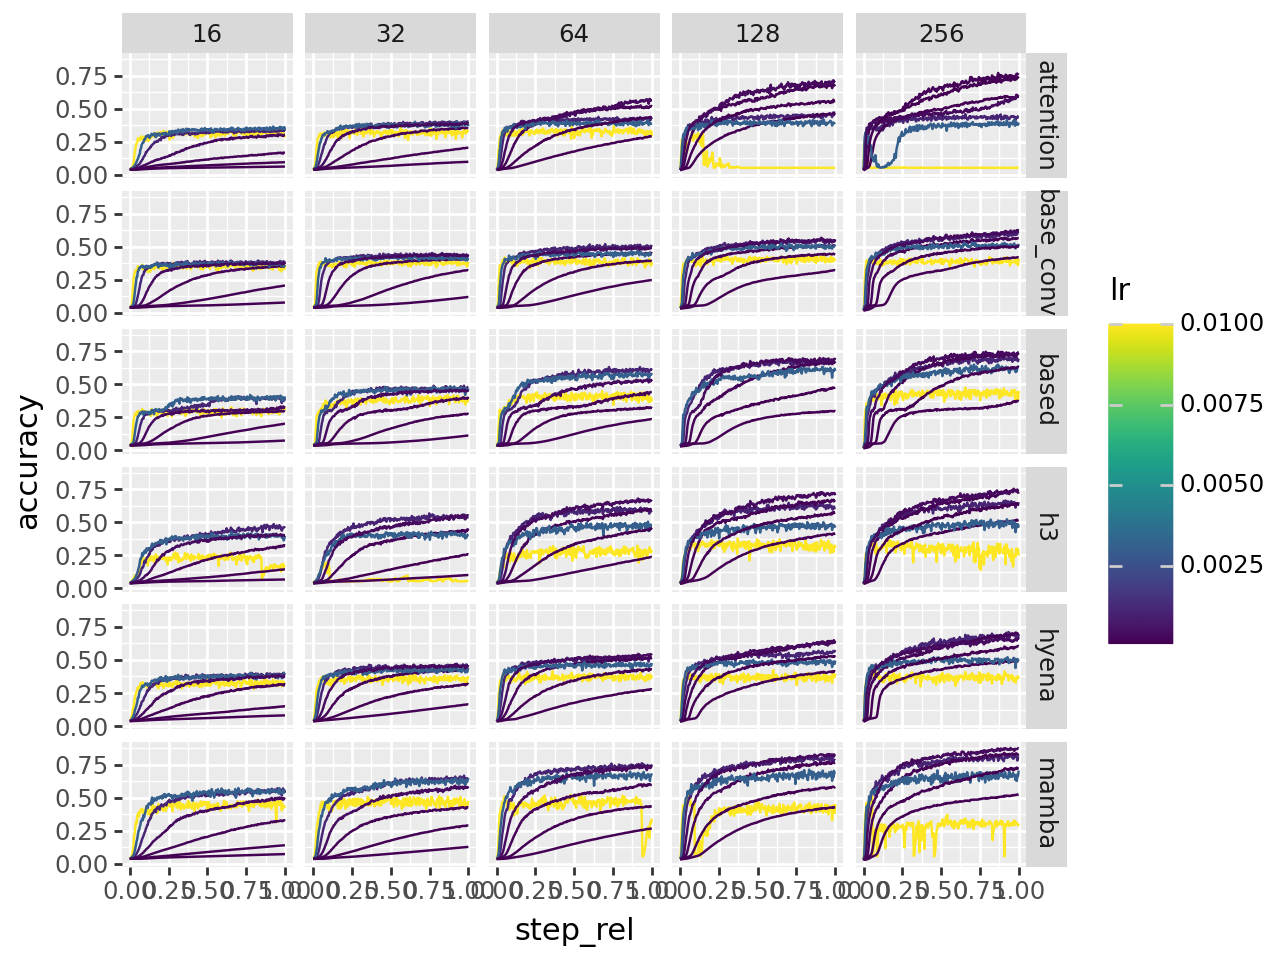

In [8]:
subset_df = df[df["variable"] == "query_item.pred_prob"]
plot = (
    p9.ggplot(subset_df, p9.aes(x="step_rel", y="value", color="lr", group="identifier")) +
    p9.geom_line() +
    p9.facet_grid("arch~dim") +
    p9.scale_x_log10() +
    # p9.scale_color_gradient(low="blue", high="red") +
    p9.labs(y="accuracy")
)
plot.show()

/juice2/scr2/aryaman/tinylang/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


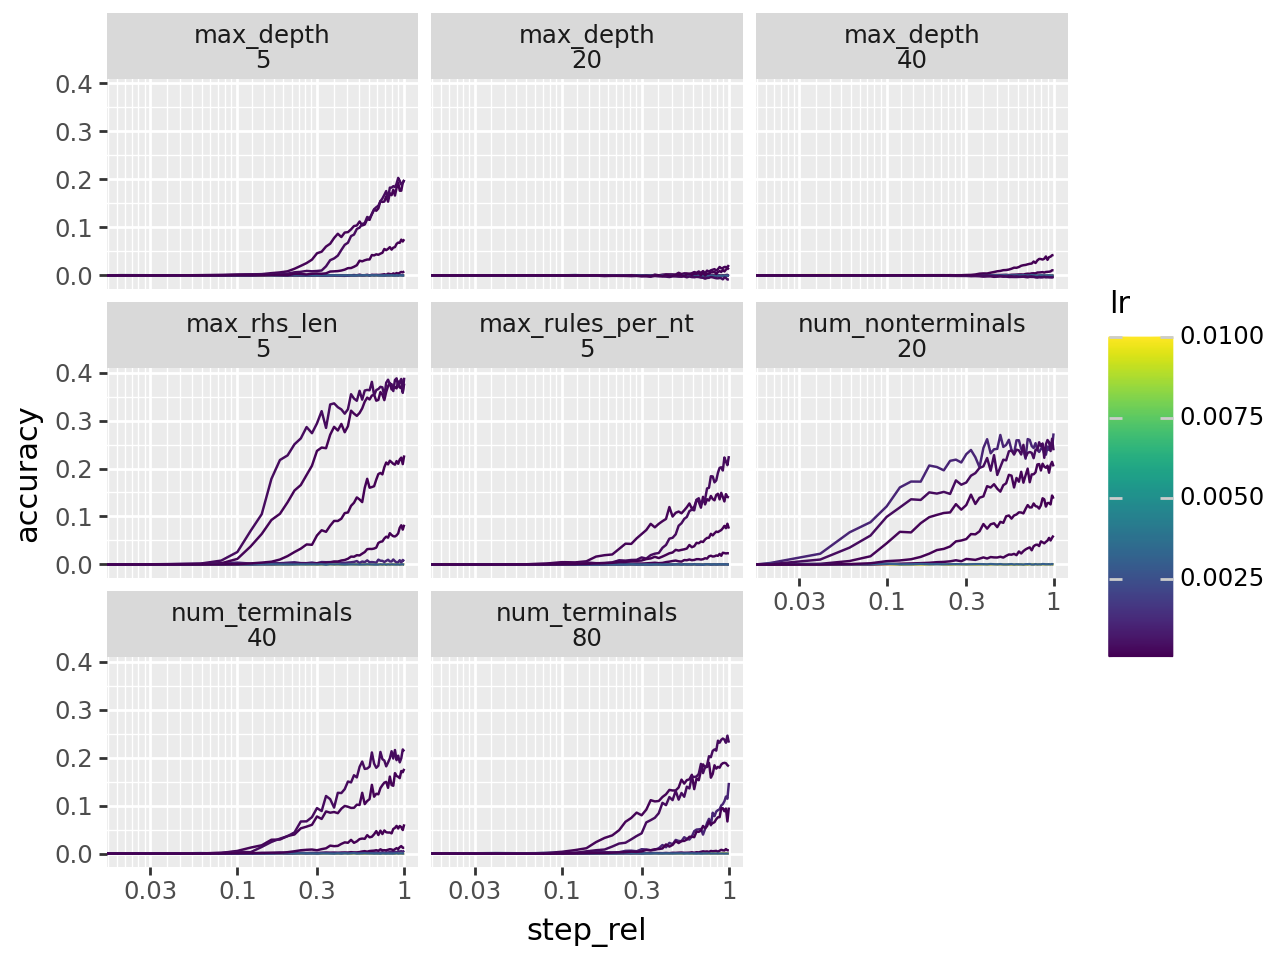

In [31]:
# eval/InterchangeEvaluator/1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff and model.config.n_embd v. eval/SummaryEvaluator/query_item.pred_prob
subset_df = df[df["variable"] == "1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff"]
plot = (
    p9.ggplot(subset_df, p9.aes(x="step_rel", y="value", color="lr", group="identifier")) +
    p9.geom_line() +
    p9.facet_wrap("~ablation + ablation_val") +
    p9.scale_x_log10() +
    # p9.scale_color_gradient(low="blue", high="red") +
    p9.labs(y="accuracy")
)
plot.show()

['step_rel', 'lr', 'ablation', 'ablation_val', '1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff', 'query_item.pred_prob', 'identifier']
2856


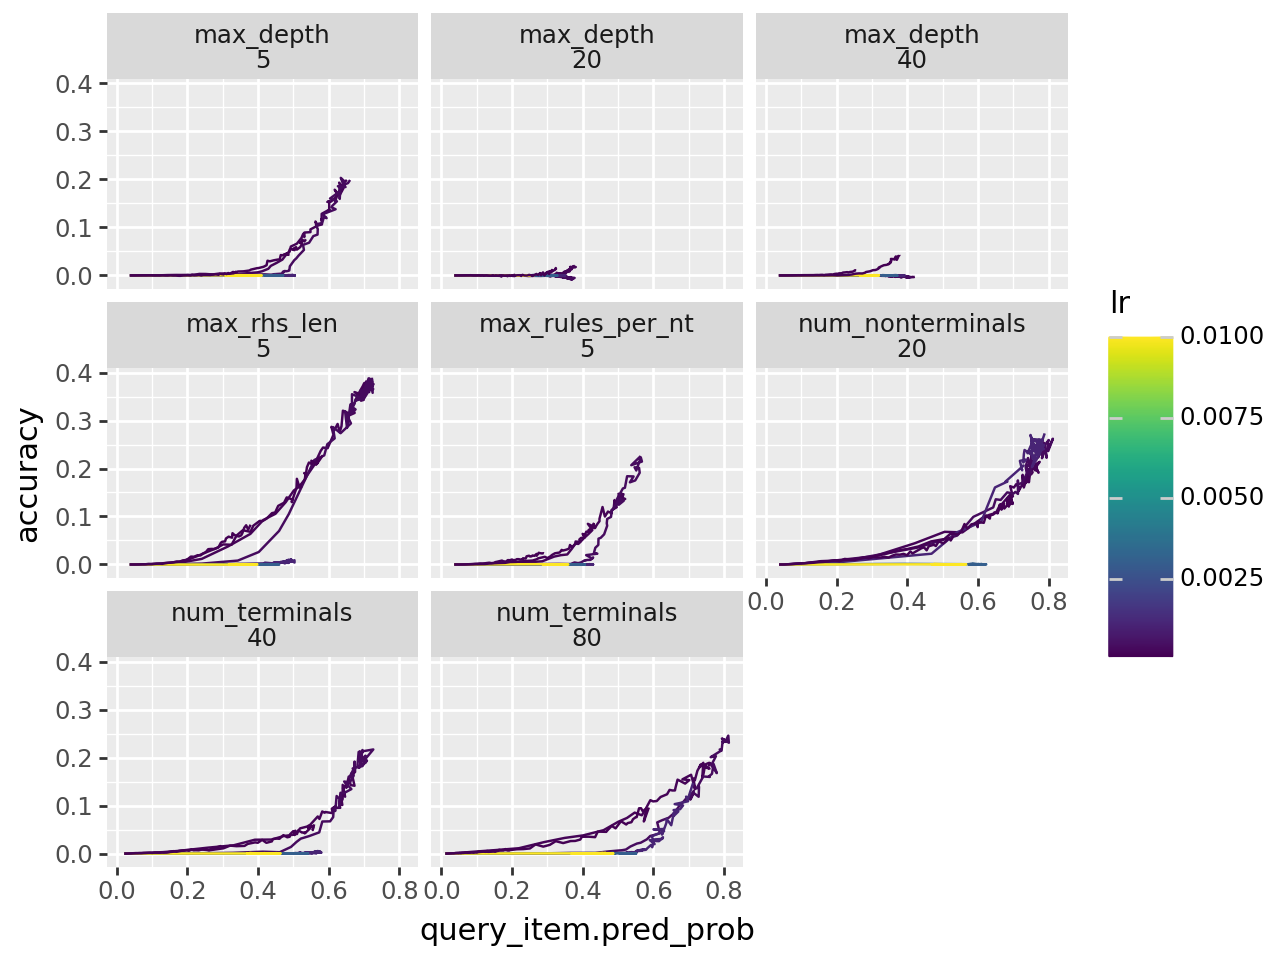

In [79]:
# eval/InterchangeEvaluator/1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff and model.config.n_embd v. eval/SummaryEvaluator/query_item.pred_prob
subset_df = df[df["variable"].isin(["1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff", "query_item.pred_prob"])]
subset_df = subset_df.pivot(index=["step_rel", "lr", "ablation", "ablation_val"], columns="variable", values="value").reset_index()
subset_df["identifier"] = subset_df["lr"].apply(lambda x: str(x))
# subset_df["lr"] = subset_df["lr"].astype(str)
subset_df = subset_df.sort_values(by=["identifier", "step_rel"]).dropna()
# print(subset_df.head())
print(list(subset_df.columns))
print(len(subset_df))
# print(subset_df)
plot = (
    p9.ggplot(subset_df, p9.aes(x="query_item.pred_prob", y="1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff", color="lr", group="identifier")) +
    p9.geom_path() +
    p9.facet_wrap("~ablation + ablation_val") +
    # p9.scale_x_log10() +
    # p9.scale_color_gradient(low="blue", high="red") +
    p9.labs(y="accuracy")
)
plot.show()


['step_rel', 'lr', 'ablation', 'ablation_val', '0.PARENT.target_item_orig.target_item_orig.attention_input.logit_diff', '1.PARENT.query_item_orig.target_item_orig.attention_input.logit_diff', 'identifier']
2856


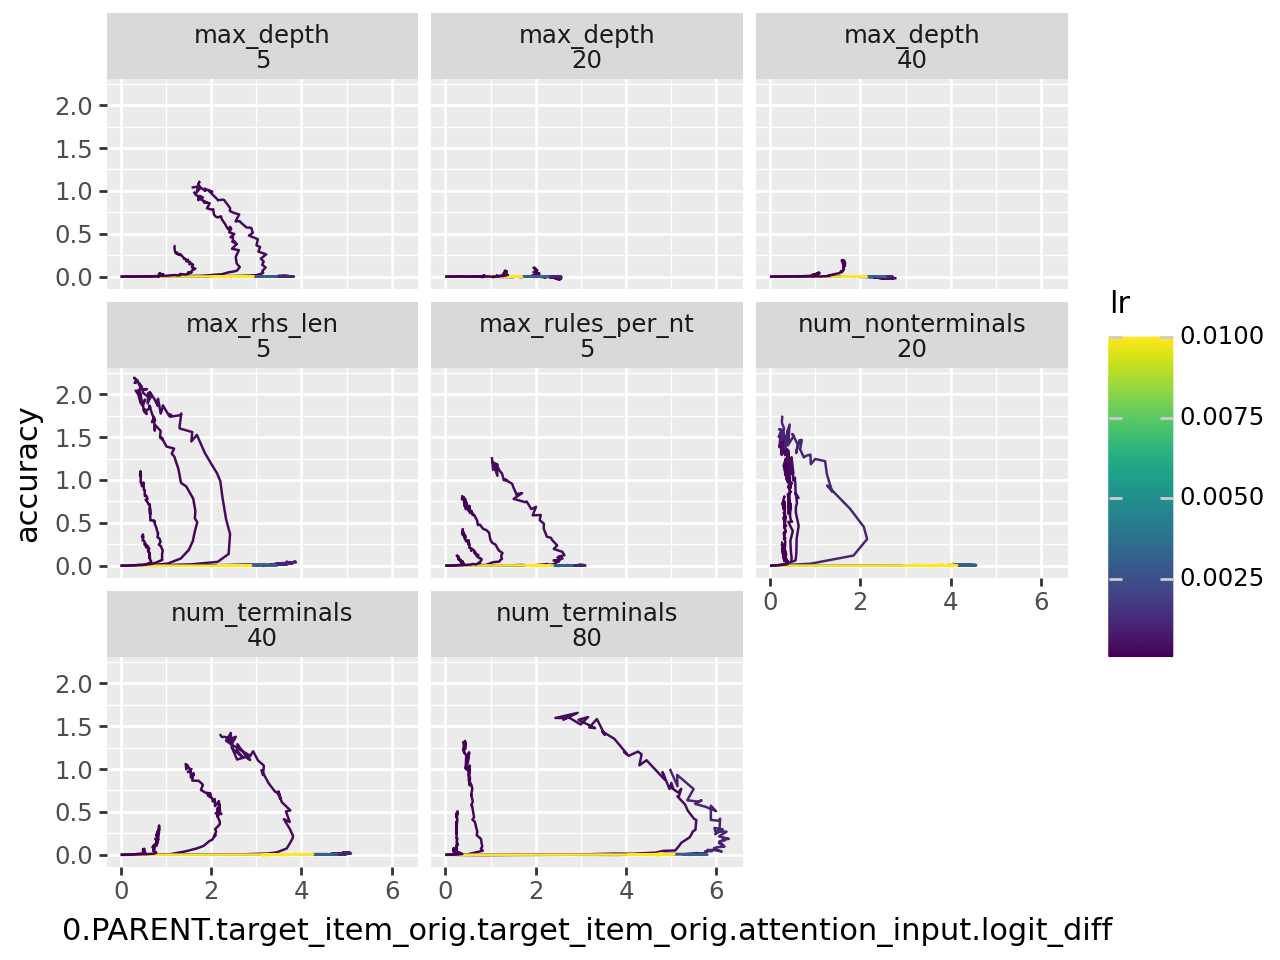

In [112]:
# eval/InterchangeEvaluator/1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff and model.config.n_embd v. eval/SummaryEvaluator/query_item.pred_prob
subset_df = df[df["variable"].isin(["1.PARENT.query_item_orig.target_item_orig.attention_input.logit_diff", "0.PARENT.target_item_orig.target_item_orig.attention_input.logit_diff"])]
subset_df = subset_df.pivot(index=["step_rel", "lr", "ablation", "ablation_val"], columns="variable", values="value").reset_index()
subset_df["identifier"] = subset_df["lr"].apply(lambda x: str(x))
# subset_df["lr"] = subset_df["lr"].astype(str)
subset_df = subset_df.sort_values(by=["identifier", "step_rel"]).dropna()
# print(subset_df.head())
print(list(subset_df.columns))
print(len(subset_df))
# print(subset_df)
plot = (
    p9.ggplot(subset_df, p9.aes(x="0.PARENT.target_item_orig.target_item_orig.attention_input.logit_diff", y="1.PARENT.query_item_orig.target_item_orig.attention_input.logit_diff", color="lr", group="identifier")) +
    p9.geom_path() +
    p9.facet_wrap("~ablation + ablation_val") +
    # p9.scale_x_log10() +
    # p9.scale_color_gradient(low="blue", high="red") +
    p9.labs(y="accuracy")
)
plot.show()


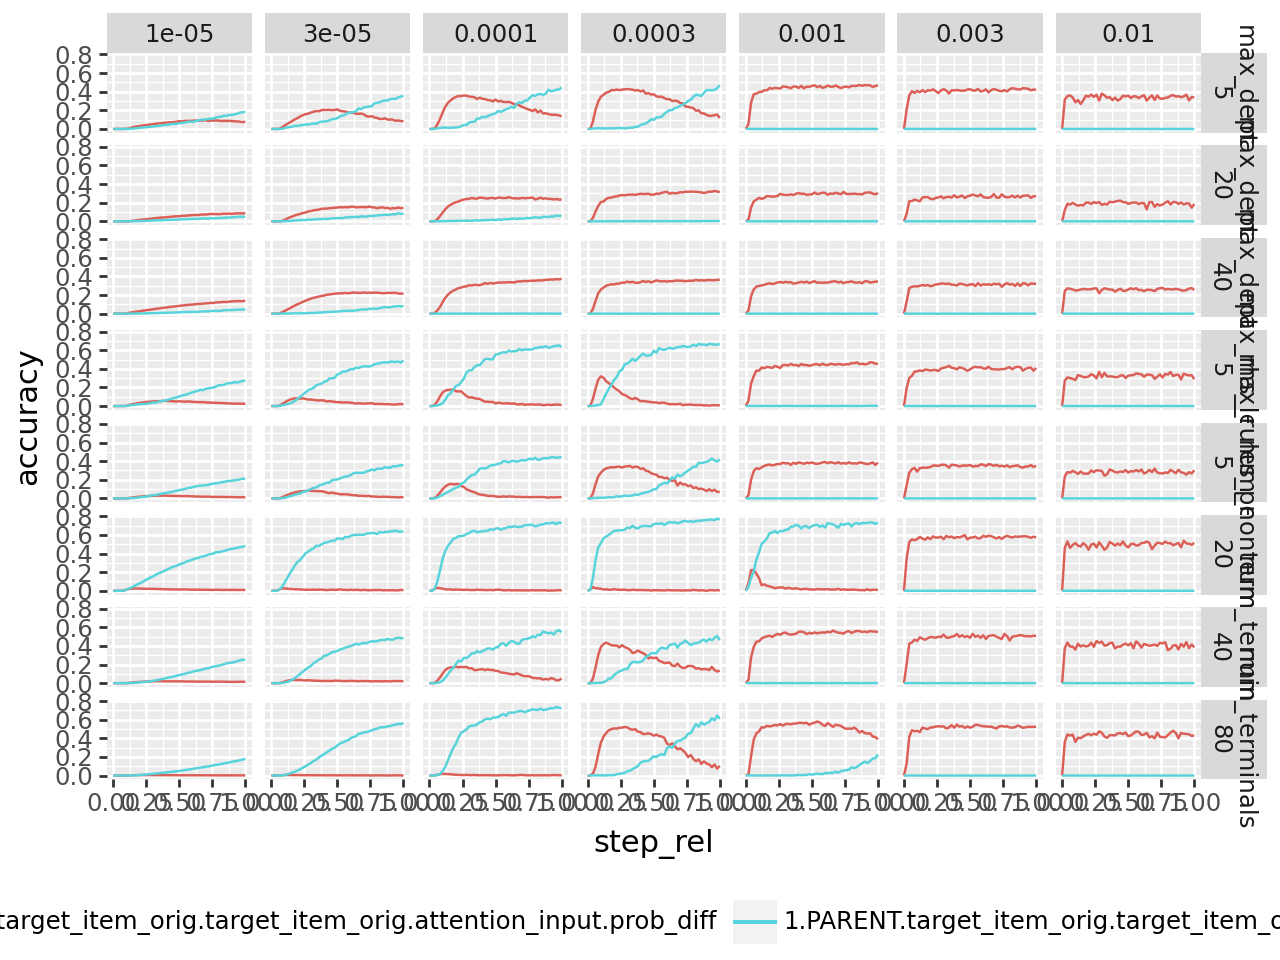

In [110]:
# eval/InterchangeEvaluator/1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff and model.config.n_embd v. eval/SummaryEvaluator/query_item.pred_prob
subset_df = df[df["variable"].isin([
    "0.PARENT.target_item_orig.target_item_orig.attention_input.prob_diff",
    "1.PARENT.target_item_orig.target_item_orig.attention_input.prob_diff"
])]
plot = (
    p9.ggplot(subset_df, p9.aes(x="step_rel", y="value", color="variable", group="variable")) +
    p9.geom_line() +
    p9.facet_grid("ablation + ablation_val~lr") +
    # p9.scale_x_log10() +
    # p9.scale_color_gradient(low="blue", high="red") +
    p9.labs(y="accuracy") +
    p9.theme(legend_position="bottom")
)
plot.show()

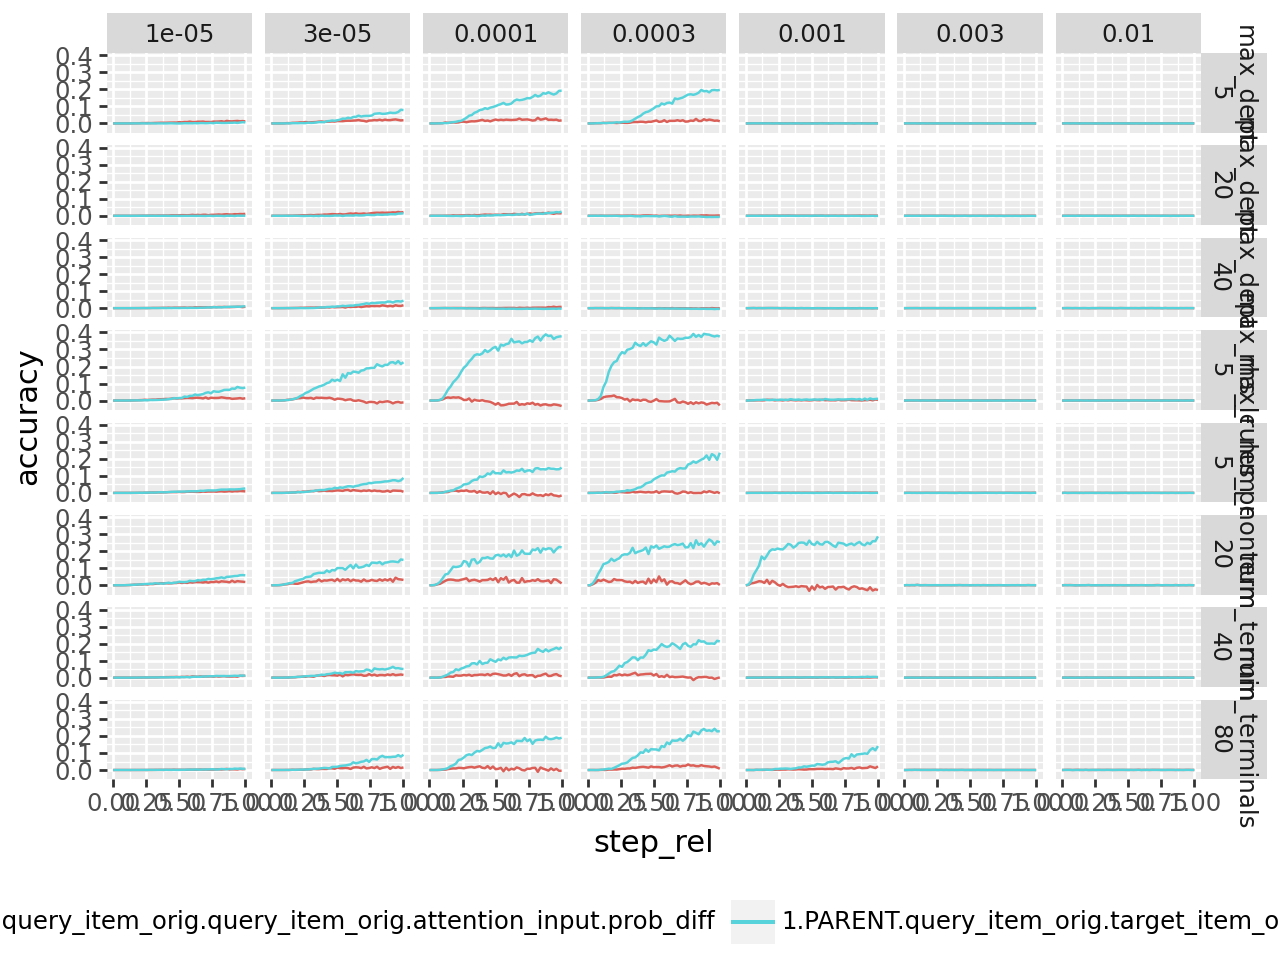

In [106]:
# eval/InterchangeEvaluator/1.PARENT.query_item_orig.target_item_orig.block_input.prob_diff and model.config.n_embd v. eval/SummaryEvaluator/query_item.pred_prob
subset_df = df[df["variable"].isin([
    "1.PARENT.query_item_orig.query_item_orig.attention_input.prob_diff",
    "1.PARENT.query_item_orig.target_item_orig.attention_input.prob_diff"
])]
plot = (
    p9.ggplot(subset_df, p9.aes(x="step_rel", y="value", color="variable", group="variable")) +
    p9.geom_line() +
    p9.facet_grid("ablation + ablation_val~lr") +
    # p9.scale_x_log10() +
    # p9.scale_color_gradient(low="blue", high="red") +
    p9.labs(y="accuracy") +
    p9.theme(legend_position="bottom")
)
plot.show()